# Library importation

In [1]:
import pandas as pd
import numpy as np
import apmodule as ap
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 3
%matplotlib inline

# User-generated functions

In [2]:
# Function to calculate Information Coefficient
def information_coefficient(data, factor, returns):
    ic = factor.corr(returns)
    return ic

In [3]:
# Function to backtest the 130/30 strategy
def backtest_130_30(df, factor, transaction_cost=0.002, start_date='2007-01-01', end_date='2023-12-31'):
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    returns = []
    dates = sorted(df['date'].unique())

    for date in dates:
        monthly_data = df[df['date'] == date]
        top_300 = monthly_data.nlargest(300, factor)
        bottom_300 = monthly_data.nsmallest(300, factor)

        long_weight = 1.3 / 300
        short_weight = -0.3 / 300

        monthly_return = long_weight * top_300['returns'].mean() + short_weight * bottom_300['returns'].mean()
        net_return = monthly_return - transaction_cost
        returns.append(net_return)

    return pd.Series(returns, index=dates)

In [4]:
# Function to optimize the strategy
def optimize_strategy(df, factor, transaction_cost=0.002, start_date='2007-01-01', end_date='2023-12-31'):
    results = []

    for num_stocks in [100, 300, 500]:
        for rebalance_freq in [1, 3, 6]:  # Monthly, Quarterly, Semi-Annually
            returns = []
            dates = sorted(df['date'].unique())
            
            for i in range(0, len(dates), rebalance_freq):
                date = dates[i]
                monthly_data = df[df['date'] == date]
                top_stocks = monthly_data.nlargest(num_stocks, factor)
                bottom_stocks = monthly_data.nsmallest(num_stocks, factor)

                long_weight = 1.3 / num_stocks
                short_weight = -0.3 / num_stocks

                monthly_return = long_weight * top_stocks['returns'].mean() + short_weight * bottom_stocks['returns'].mean()
                net_return = monthly_return - transaction_cost
                returns.append(net_return)
            
            cumulative_return = np.sum(returns)
            results.append((num_stocks, rebalance_freq, cumulative_return))

    results_df = pd.DataFrame(results, columns=['Num_Stocks', 'Rebalance_Freq', 'Cumulative_Return'])
    return results_df

# Load Files

In [5]:
prices = pd.read_csv('Prices.csv', parse_dates=['date']).set_index(['id']).squeeze()
prices.head()

,date,price
id,,
10000,1986-01-31,4.374997
10000,1986-02-28,3.249997
10000,1986-03-31,4.437498
10000,1986-04-30,3.999996
10000,1986-05-30,3.109373


In [6]:
prices.shape

(2676412, 2)

In [7]:
intcov = pd.read_csv('INTCOV.csv', parse_dates=['date']).set_index(['id']).squeeze()
intcov.head()

,date,intcov
id,,
10001,1986-11-28,-0.036508
10001,1986-12-31,-0.035019
10001,1987-01-30,-0.036436
10001,1987-02-27,-0.055301
10001,1987-03-31,-0.058922


In [8]:
intcov.shape

(1845124, 2)

In [9]:
cash_debt = pd.read_csv('CASH_DEBT.csv', parse_dates=['date']).set_index(['id']).squeeze()
cash_debt.head()

,date,cash_debt
id,,
10001,1987-08-31,0.093349
10001,1987-09-30,0.096959
10001,1987-10-30,0.098956
10001,1987-11-30,0.098332
10001,1987-12-31,0.100232


In [10]:
cash_debt.shape

(2286487, 2)

In [11]:
ocf_lct = pd.read_csv('OCF_LCT.csv', parse_dates=['date']).set_index(['id']).squeeze()
ocf_lct.head()

,date,ocf_lct
id,,
10001,1986-11-28,0.064810
10001,1986-12-31,0.063030
10001,1987-01-30,0.061564
10001,1987-02-27,-0.141271
10001,1987-03-31,-0.142123


In [12]:
ocf_lct.shape

(1967379, 2)

In [13]:
# Data Preprocessing
data = pd.merge(prices, intcov, on=['id', 'date'])
data = pd.merge(data, ocf_lct, on=['id', 'date'])
data = pd.merge(data, cash_debt, on=['id', 'date'])

In [14]:
data.head()

,date,price,intcov,ocf_lct,cash_debt
id,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232


In [15]:
#  syntenic “Average” factor built as the average of the three  financial ratios
data['average_factor'] = data[['intcov', 'ocf_lct', 'cash_debt']].mean(axis=1)

In [16]:
data.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor
id,,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959,0.049351
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956,0.048978
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332,0.020751
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232,0.022729


In [17]:
# Calculate returns (percentage change in price)
data['returns'] = data.groupby('id')['price'].pct_change()

In [18]:
df= pd.DataFrame(data)
print(df)

            date       price    intcov   ocf_lct  cash_debt  average_factor  \
id                                                                            
10001 1987-08-31    0.540697 -0.048930  0.097231   0.093349        0.047217   
10001 1987-09-30    0.528635 -0.047790  0.098882   0.096959        0.049351   
10001 1987-10-30    0.539207 -0.051882  0.099862   0.098956        0.048978   
10001 1987-11-30    0.523348 -0.057535  0.021457   0.098332        0.020751   
10001 1987-12-31    0.505798 -0.053371  0.021327   0.100232        0.022729   
...          ...         ...       ...       ...        ...             ...   
93436 2023-08-31  258.080151  0.069318  0.473137   0.514704        0.352386   
93436 2023-09-29  250.220062  0.069036  0.450311   0.464847        0.328065   
93436 2023-10-31  200.840134  0.067597  0.417202   0.464340        0.316380   
93436 2023-11-30  240.080078  0.065708  0.413005   0.462148        0.313620   
93436 2023-12-29  248.480000  0.062451  0.411560   0

# 1. Statistical Analysis

In [19]:
# Calculate Information Coefficient for Interest Coverage Ratio
factor = df['intcov']
returns = df['returns']
ic_intcov = information_coefficient(df, factor, returns)
print(f"IC for Interest Coverage Ratio: {ic_intcov}")

IC for Interest Coverage Ratio: 0.003581751746348746


In [20]:
# Calculate Information Coefficient for Cash Flow to Current Liabilities Ratio
factor = df['ocf_lct']
returns = df['returns']
ic_ocflct = information_coefficient(df, factor, returns)
print(f"IC for Cash Flow to Current Liabilities Ratio: {ic_ocflct}")

IC for Cash Flow to Current Liabilities Ratio: 0.014808973549208217


In [21]:
# Calculate Information Coefficient for Cash Flow to Debt Ratio
factor = df['cash_debt']
returns = df['returns']
ic_cashdebt = information_coefficient(df, factor, returns)
print(f"IC for Cash Flow to Debt Ratio: {ic_cashdebt}")

IC for Cash Flow to Debt Ratio: 0.012506126926589064


In [22]:
# Calculate Information Coefficient for Average factor
factor = df['average_factor']
returns = df['returns']
ic_avg = information_coefficient(df, factor, returns)
print(f"IC for Average Factor: {ic_avg}")

IC for Average Factor: 0.014522585886653849


In [23]:
# Define time periods (e.g., decades)
time_periods = [(1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019), (2020, 2023)]

ic_over_time = {}

for start, end in time_periods:
    period_data = df[(df['date'] >= f'{start}-01-01') & (df['date'] <= f'{end}-12-31')]
    
    ic_over_time[f'{start}-{end}'] = {
        'IC_intcov': information_coefficient(df, period_data['intcov'], period_data['returns']),
        'IC_ocf_lct': information_coefficient(df, period_data['ocf_lct'], period_data['returns']),
        'IC_cash_debt': information_coefficient(df, period_data['cash_debt'], period_data['returns']),
        'IC_average_factor': information_coefficient(df, period_data['average_factor'], period_data['returns'])
    }

# Print IC over time
for period, ics in ic_over_time.items():
    print(f"\nPeriod: {period}")
    for ratio, ic in ics.items():
        print(f"{ratio}: {ic}")


Period: 1980-1989
IC_intcov: 0.013039990990215779
IC_ocf_lct: 0.013933432999145292
IC_cash_debt: 0.025637716471722673
IC_average_factor: 0.02283742508174354

Period: 1990-1999
IC_intcov: 0.00434701240956957
IC_ocf_lct: 0.01121758825523836
IC_cash_debt: 0.006779255558957974
IC_average_factor: 0.009709920157061678

Period: 2000-2009
IC_intcov: 0.005154722856950064
IC_ocf_lct: 0.02219981381189242
IC_cash_debt: 0.015519531086355983
IC_average_factor: 0.020182775791541877

Period: 2010-2019
IC_intcov: 0.0011809063711400003
IC_ocf_lct: 0.011095188838960105
IC_cash_debt: 0.011506594901751975
IC_average_factor: 0.011744692272878877

Period: 2020-2023
IC_intcov: 0.012131596221958783
IC_ocf_lct: 0.012513746302608781
IC_cash_debt: 0.012548243002356836
IC_average_factor: 0.013720522212828386


In [24]:
# Extract data for plotting

periods = list(ic_over_time.keys())
ic_intcov = [ic_over_time[period]['IC_intcov'] for period in periods]
ic_ocf_lct = [ic_over_time[period]['IC_ocf_lct'] for period in periods]
ic_cash_debt = [ic_over_time[period]['IC_cash_debt'] for period in periods]
ic_average_factor = [ic_over_time[period]['IC_average_factor'] for period in periods]

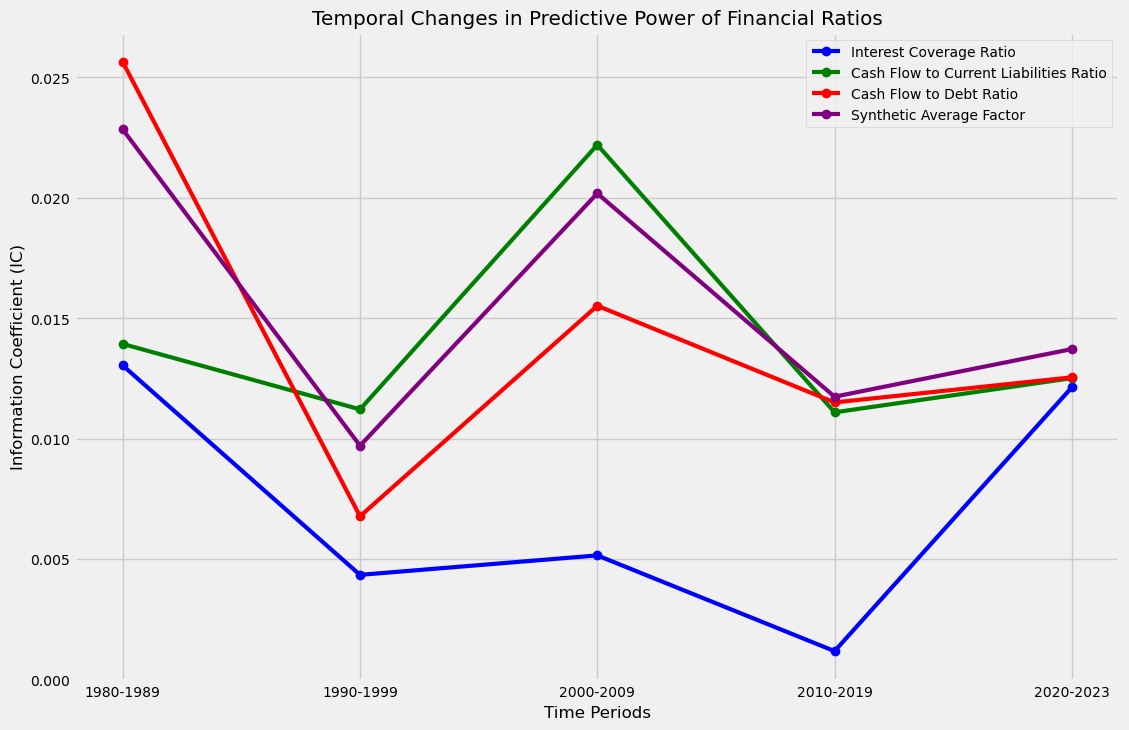

In [25]:
plt.figure(figsize=(12, 8))

# Plotting Interest Coverage Ratio
plt.plot(periods, ic_intcov, marker='o', label='Interest Coverage Ratio', color='blue')

# Plotting Cash Flow to Current Liabilities Ratio
plt.plot(periods, ic_ocf_lct, marker='o', label='Cash Flow to Current Liabilities Ratio', color='green')

# Plotting Cash Flow to Debt Ratio
plt.plot(periods, ic_cash_debt, marker='o', label='Cash Flow to Debt Ratio', color='red')

# Plotting Synthetic Average Factor
plt.plot(periods, ic_average_factor, marker='o', label='Synthetic Average Factor', color='purple')

# Adding labels and title
plt.xlabel('Time Periods')
plt.ylabel('Information Coefficient (IC)')
plt.title('Temporal Changes in Predictive Power of Financial Ratios')
plt.legend()
plt.grid(True)
plt.show()

# 2. Backtesting

In [26]:
print(df.isnull().sum())

date                  0
price                 0
intcov                0
ocf_lct               0
cash_debt             0
average_factor        0
returns           15891
dtype: int64


In [27]:
df['returns'].fillna(0, inplace=True)

In [28]:
print(df.isnull().sum())

date              0
price             0
intcov            0
ocf_lct           0
cash_debt         0
average_factor    0
returns           0
dtype: int64


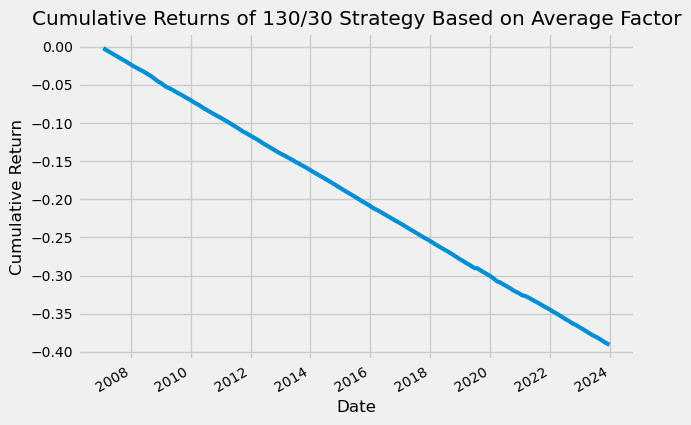

In [29]:
strategy_returns = backtest_130_30(df, 'average_factor')

strategy_returns.cumsum().plot()
plt.title('Cumulative Returns of 130/30 Strategy Based on Average Factor')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [30]:
optimization_results = optimize_strategy(df, 'average_factor')
print(optimization_results)

   Num_Stocks  Rebalance_Freq  Cumulative_Return
0         100               1          -0.943153
1         100               3          -0.315307
2         100               6          -0.159618
3         300               1          -1.033349
4         300               3          -0.343772
5         300               6          -0.172238
6         500               1          -1.053805
7         500               3          -0.351058
8         500               6          -0.176142


### Interpretation of the ResultsEffect of Number of Stocks:

For each rebalancing frequency, increasing the number of stocks (from 100 to 500) tends to result in more negative cumulative returns.
This might indicate that selecting fewer stocks (100) is slightly better than selecting more stocks (500) in terms of minimizing losses, but all selections still result in negative returns.
Effect of Rebalancing Frequency:

For each number of stocks, more frequent rebalancing (e.g., monthly) results in more negative cumulative returns compared to less frequent rebalancing (e.g., semi-annually).
This suggests that less frequent rebalancing (6 months) results in less negative returns compared to more frequent rebalancing (1 month).od.


In [31]:
gp = pd.read_csv('GP.csv', parse_dates=['date']).set_index(['id', 'date']).squeeze()
gp.head()

id     date      
10001  1986-11-28   -1.225507
       1986-12-31   -1.243168
       1987-01-30   -1.238661
       1987-02-27   -0.620267
       1987-03-31   -0.565438
Name: gp, dtype: float64

In [32]:
mom12 = pd.read_csv('MOM12.csv', parse_dates=['date']).set_index(['id', 'date']).squeeze()
mom12.head()

id     date      
10000  1987-01-30   -4.137997
       1987-02-27   -4.797531
       1987-03-31   -4.261258
       1987-04-30   -5.959072
       1987-05-29   -5.653565
Name: mom12, dtype: float64

In [33]:
tvol = pd.read_csv('TVOL.csv', parse_dates=['date']).set_index(['id', 'date']).squeeze()
tvol.head()

id     date      
10001  1996-07-31   -0.057004
       1996-08-30   -0.056819
       1996-09-30   -0.056647
       1996-10-31   -0.056551
       1996-11-29   -0.056348
Name: tvol, dtype: float64

In [34]:
epq = pd.read_csv('EPQ.csv', parse_dates=['date']).set_index(['id','date']).squeeze()
epq.head()

id     date      
10001  1986-11-28   -0.042355
       1986-12-31   -0.029326
       1987-01-30   -0.060960
       1987-02-27    0.209572
       1987-03-31    0.171081
Name: epq, dtype: float64

In [35]:
market_cap = pd.read_csv('market_cap.csv', parse_dates=['date']).set_index(['id', 'date']).squeeze()
market_cap.head()

id     date      
10000  1986-01-31    16100.00000
       1986-02-28    11960.00000
       1986-03-31    16330.00000
       1986-04-30    15172.00000
       1986-05-30    11793.87834
Name: market_cap, dtype: float64

In [36]:
int_rates = pd.read_csv('INT_RATES.csv', parse_dates=['date']).set_index(['date']).squeeze()
int_rates.head()

,1YTR,10YTR
date,,
1979-01-31,10.13,8.95
1979-02-28,10.33,9.17
1979-03-30,10.17,9.11
1979-04-30,10.29,9.35
1979-05-31,9.91,9.06


In [37]:
df.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor,returns
id,,,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217,0.000000
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959,0.049351,-0.022308
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956,0.048978,0.020000
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332,0.020751,-0.029412
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232,0.022729,-0.033535


In [38]:
df = df.merge(gp, on=['id', 'date'], how='left')
df.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor,returns,gp
id,,,,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217,0.000000,-0.994403
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959,0.049351,-0.022308,-0.982979
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956,0.048978,0.020000,-1.051432
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332,0.020751,-0.029412,-1.611812
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232,0.022729,-0.033535,-1.596944


In [39]:
df = df.merge(mom12, on=['id', 'date'], how='left')
df.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor,returns,gp,mom12
id,,,,,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217,0.000000,-0.994403,-0.029368
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959,0.049351,-0.022308,-0.982979,0.000910
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956,0.048978,0.020000,-1.051432,-0.150722
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332,0.020751,-0.029412,-1.611812,0.521028
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232,0.022729,-0.033535,-1.596944,0.443773


In [40]:
df = df.merge(tvol, on=['id', 'date'], how='left')
df.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor,returns,gp,mom12,tvol
id,,,,,,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217,0.000000,-0.994403,-0.029368,NaN
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959,0.049351,-0.022308,-0.982979,0.000910,NaN
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956,0.048978,0.020000,-1.051432,-0.150722,NaN
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332,0.020751,-0.029412,-1.611812,0.521028,NaN
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232,0.022729,-0.033535,-1.596944,0.443773,NaN


In [41]:
df = df.merge(epq, on=['id', 'date'], how='left')
df.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor,returns,gp,mom12,tvol,epq
id,,,,,,,,,,,
10001,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217,0.000000,-0.994403,-0.029368,NaN,0.036232
10001,1987-09-30,0.528635,-0.047790,0.098882,0.096959,0.049351,-0.022308,-0.982979,0.000910,NaN,0.043817
10001,1987-10-30,0.539207,-0.051882,0.099862,0.098956,0.048978,0.020000,-1.051432,-0.150722,NaN,0.035895
10001,1987-11-30,0.523348,-0.057535,0.021457,0.098332,0.020751,-0.029412,-1.611812,0.521028,NaN,-0.106152
10001,1987-12-31,0.505798,-0.053371,0.021327,0.100232,0.022729,-0.033535,-1.596944,0.443773,NaN,-0.122997


In [42]:
df = df.merge(int_rates, on=['date'])
df.head()

,date,price,intcov,ocf_lct,cash_debt,average_factor,returns,gp,mom12,tvol,epq,1YTR,10YTR
0,1987-08-31,0.540697,-0.048930,0.097231,0.093349,0.047217,0.000000,-0.994403,-0.029368,NaN,0.036232,7.23,9.0
1,1987-08-31,5.820645,-0.221290,-0.205750,-0.629535,-0.352192,-0.500000,-1.684118,-1.767309,NaN,-0.188957,7.23,9.0
2,1987-08-31,17.999950,-0.025773,-0.035545,0.087031,0.008571,0.200000,0.513859,-0.070152,NaN,0.350831,7.23,9.0
3,1987-08-31,1.749389,-0.009246,-0.141769,0.130985,-0.006677,-0.095238,1.547350,0.890530,NaN,0.212032,7.23,9.0
4,1987-08-31,22.859614,-0.003709,-0.003573,0.130020,0.040913,0.018726,0.189006,0.836414,NaN,0.195547,7.23,9.0


In [43]:
print(df.isnull().sum())
df.fillna(0, inplace=True)

date                   0
price                  0
intcov                 0
ocf_lct                0
cash_debt              0
average_factor         0
returns                0
gp                132024
mom12              92139
tvol              811185
epq                81116
1YTR                   0
10YTR                  0
dtype: int64


In [44]:
print(df.isnull().sum())

date              0
price             0
intcov            0
ocf_lct           0
cash_debt         0
average_factor    0
returns           0
gp                0
mom12             0
tvol              0
epq               0
1YTR              0
10YTR             0
dtype: int64


# 4. Addressing the CIO's Concerns

In [45]:
def information_coefficient(df, factor, returns):
    ic, _ = spearmanr(df[factor], df[returns])
    return ic

In [46]:
# Calculate IC for new factors
new_factors = ['intcov', 'ocf_lct', 'cash_debt']
classic_factors = ['epq', 'mom12', 'gp', 'tvol']

new_factors_ic = {factor: information_coefficient(df, factor, 'returns') for factor in new_factors}

In [47]:
# Calculate IC for classic factors
classic_factors_ic = {factor: information_coefficient(df, factor, 'returns') for factor in classic_factors}

In [48]:
# Combine results
ic_results = pd.DataFrame({
    'Factor': new_factors + classic_factors,
    'Information Coefficient': list(new_factors_ic.values()) + list(classic_factors_ic.values())
})

print("Information Coefficient Results:")
print(ic_results)

Information Coefficient Results:
      Factor  Information Coefficient
0     intcov                 0.013775
1    ocf_lct                 0.067358
2  cash_debt                 0.054076
3        epq                 0.082276
4      mom12                 0.049975
5         gp                 0.042841
6       tvol                -0.025820


In [ ]:
# Plotting IC Comparison
plt.figure(figsize=(10, 6))
plt.bar(ic_results['Factor'], ic_results['Information Coefficient'], color='skyblue')
plt.xlabel('Factors')
plt.ylabel('Information Coefficient')
plt.title('Information Coefficient of New and Classic Factors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define high interest rate periods
interest_rate_columns = ['1YTR', '10YTR']
df['average_interest_rate'] = df[interest_rate_columns].mean(axis=1)
mean_interest_rate = df['average_interest_rate'].mean()
high_interest_periods = df[df['average_interest_rate'] > mean_interest_rate]

In [ ]:
# Calculate IC for new factors during high interest rate periods
high_interest_ic = {factor: information_coefficient(high_interest_periods, factor, 'returns') for factor in new_factors}

In [ ]:
# Combine results
high_interest_ic_results = pd.DataFrame({
    'Factor': new_factors,
    'Overall IC': list(new_factors_ic.values()),
    'High Interest Rate IC': list(high_interest_ic.values())
})

print("High Interest Rate IC Results:")
print(high_interest_ic_results)

## Machine Learning

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Create the target variable: 1 if next month's return is positive, else 0
df['target'] = (df['returns'].shift(-1) > 0).astype(int)

In [ ]:
df.head()

In [ ]:
# Filter the data for the specified date range
df_filtered = df[(df['date'] >= '2007-01-01') & (df['date'] <= '2023-12-31')].dropna()

In [ ]:
# Prepare features and target for the decision tree
features = ['intcov', 'ocf_lct', 'cash_debt', 'epq', 'mom12', 'gp', 'tvol']
target = 'target'

X = df_filtered[features]
y = df_filtered[target]

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Initialize the Decision Tree Classifier
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model
tree_model.fit(X_scaled, y)

In [ ]:
# Perform 10-fold cross-validation and calculate the accuracy
cv_scores = cross_val_score(tree_model, X_scaled, y, cv=10, scoring='accuracy')
mean_cv_accuracy = cv_scores.mean()

print(f'10-Fold Cross-Validation Accuracy: {mean_cv_accuracy:.4f}')

In [ ]:
# Feature importance
importances = tree_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)